<a href="https://colab.research.google.com/github/KayKozaronek/03_Courses/blob/master/NLP_Course_Week_3_Exercise_Question.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import json
import tensorflow as tf
import csv 
import random 
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

In [0]:
embedding_dim = 100
max_length = 16
trunc_type = "post"
padding_type = "post"
oov_tok = "<OOV>"
training_size= 160000#160365 #Your dataset size here. Experiment using smaller values (i.e. 16000), but don't forget to train on at least 160000 to see the best effects
test_portion = 0.1

Note that I cleaned the Stanford dataset to remove LATIN1 encoding to make it easier for Python CSV reader

You can do that yourself with:
iconv -f LATIN1 -t UTF8 training.1600000.processed.noemoticon.csv -o training_cleaned.csv

In [46]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv

--2020-05-22 12:55:25--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.184.128, 2a00:1450:400c:c08::80
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.184.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/tmp/training_cleaned.csv’

/tmp/training_clean 100%[===================>] 227.87M  44.4MB/s    in 5.1s    

2020-05-22 12:55:31 (44.4 MB/s) - ‘/tmp/training_cleaned.csv’ saved [238942690/238942690]



In [0]:
num_sentences = 0 

corpus=[]

with open("/tmp/training_cleaned.csv") as csvfile:
  reader = csv.reader(csvfile, delimiter =",")
  for row in reader:
    # Your Code here. Create list items where the first item is the text, found in row[5]
    # and the second is the label. Note that the label is a '0' or a '4' in the text. 
    # When it's the former, make your label to be 0, otherwise 1. 
    # Keep a count of the number of sentences in num_sentences
    # YOUR CODE HERE
    list_item = []
    list_item.append(row[5])
    current_label = row[0]
    if current_label == "0":
      list_item.append(0)
    else:
      list_item.append(1)
    num_sentences = num_sentences + 1
    corpus.append(list_item)

In [48]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

# Expected Output:
# 1600000
# 1600000
# ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [0]:
sentences = []
labels = []

random.shuffle(corpus)
for x in range(training_size):
  sentences.append(corpus[x][0])
  labels.append(corpus[x][1])

In [50]:
print(len(sentences))
print(len(labels))

160000
160000


In [0]:
import numpy as np

sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])


tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, 
                       maxlen=max_length, 
                       padding=padding_type, 
                       truncating=trunc_type)

split = int(test_portion * training_size)

test_sequences = padded[0:split]
training_sequences = padded[split:training_size]

test_labels = np.array(labels[0:split])
training_labels = np.array(labels[split:training_size])

In [52]:
print(vocab_size)
print(word_index["i"])
# Expected Output
# 138858 ( Will most probably vary due to the random shuffle)
# 1

138409
1


Note this is the 100 dimension version of GloVe from Stanford
It is unzipped and hosted on the following  website to make this notebook easier

In [53]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt

--2020-05-22 12:55:49--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.15.128, 2a00:1450:400c:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.15.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M  41.2MB/s    in 8.0s    

2020-05-22 12:55:58 (41.2 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [0]:
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [55]:
print(len(embeddings_matrix))
# Expected Output
# 138859

138410


In [0]:
model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size +1,
                                  embedding_dim,
                                  input_length=max_length,
                                  #weights=[embeddings_matrix],
                                  trainable = False),
        # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv1D(64,5,activation ="relu"),
        tf.keras.layers.MaxPooling1D(pool_size =4),
        tf.keras.layers.LSTM(32), #, return_sequences = True)),
        #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        #tf.keras.layers.Conv1D(32,(3,), activation ="relu"),
        #tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(1, activation ="sigmoid")])

In [57]:
model.compile(optimizer= "adam",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 16, 100)           13841000  
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 100)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 3, 64)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 13,885,513
Trainable params: 44,513
Non-trainable params: 13,841,000
_____________________________________

In [58]:
num_epochs = 50

history = model.fit(training_sequences, training_labels,
                    epochs = num_epochs,
                    validation_data= (training_sequences, training_labels),
                    verbose =1)

print("Training Complete")

Epoch 1/50
4500/4500 [==============================] - 33s 7ms/step - loss: 0.6106 - accuracy: 0.6558 - val_loss: 0.5476 - val_accuracy: 0.7185
Epoch 2/50
4500/4500 [==============================] - 32s 7ms/step - loss: 0.5579 - accuracy: 0.7063 - val_loss: 0.5157 - val_accuracy: 0.7469
Epoch 3/50
4500/4500 [==============================] - 32s 7ms/step - loss: 0.5377 - accuracy: 0.7230 - val_loss: 0.4972 - val_accuracy: 0.7594
Epoch 4/50
4500/4500 [==============================] - 32s 7ms/step - loss: 0.5257 - accuracy: 0.7315 - val_loss: 0.4939 - val_accuracy: 0.7699
Epoch 5/50
4500/4500 [==============================] - 32s 7ms/step - loss: 0.5178 - accuracy: 0.7374 - val_loss: 0.4840 - val_accuracy: 0.7701
Epoch 6/50
4500/4500 [==============================] - 33s 7ms/step - loss: 0.5108 - accuracy: 0.7425 - val_loss: 0.4680 - val_accuracy: 0.7805
Epoch 7/50
4500/4500 [==============================] - 32s 7ms/step - loss: 0.5045 - accuracy: 0.7479 - val_loss: 0.4758 - val_ac

<Figure size 432x288 with 0 Axes>

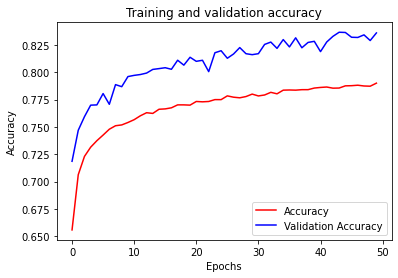

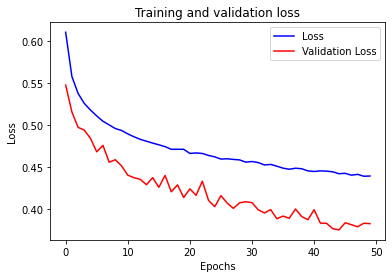

<Figure size 432x288 with 0 Axes>

In [62]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt 


#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, "r")
plt.plot(epochs, val_acc, "b")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, "b")
plt.plot(epochs, val_loss, "r")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!